In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joypy
import datetime
import gc
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import random

root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"

def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

In [3]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"
root_ai_Zamuro = f"{root}/Zamuro/AI_Caract/AI_Zamuro.csv"
root_vggish_Zamuro = f"{root}/Zamuro/vggish/Features_vggish"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)
ai = pd.read_csv(root_ai_Zamuro, index_col=0)
ai.dropna(inplace=True)
ai.set_index("file",inplace=True, drop=True)
ai.drop(columns=["Date"], inplace=True)
def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

# AE

### Covers

In [12]:
accuracies_ae_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_covers.npy")
f1_scores_ae_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_covers.npy")
recalls_ae_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_covers.npy")

### Hours

In [13]:
accuracies_ae_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ae_unflat_hours.npy")
f1_scores_ae_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ae_unflat_hours.npy")
recalls_ae_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ae_unflat_hours.npy")

# VGGISH

### Covers

In [14]:
accuracies_vgg_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_covers.npy")
f1_scores_vgg_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_covers.npy")
recalls_vgg_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_covers.npy")

### Hours

In [15]:
accuracies_vgg_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_hours.npy")
f1_scores_vgg_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_hours.npy")
recalls_vgg_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_hours.npy")

# Acoustic Indices (AIs)

### Covers

In [19]:
accuracies_ai_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_covers.npy")
f1_scores_ai_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_covers.npy")
recalls_ai_covers = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_covers.npy")

### Hours

In [35]:
accuracies_ai_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_hours.npy")
f1_scores_ai_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_hours.npy")
recalls_ai_hours = np.load(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_hours.npy")

# Graphics Covers

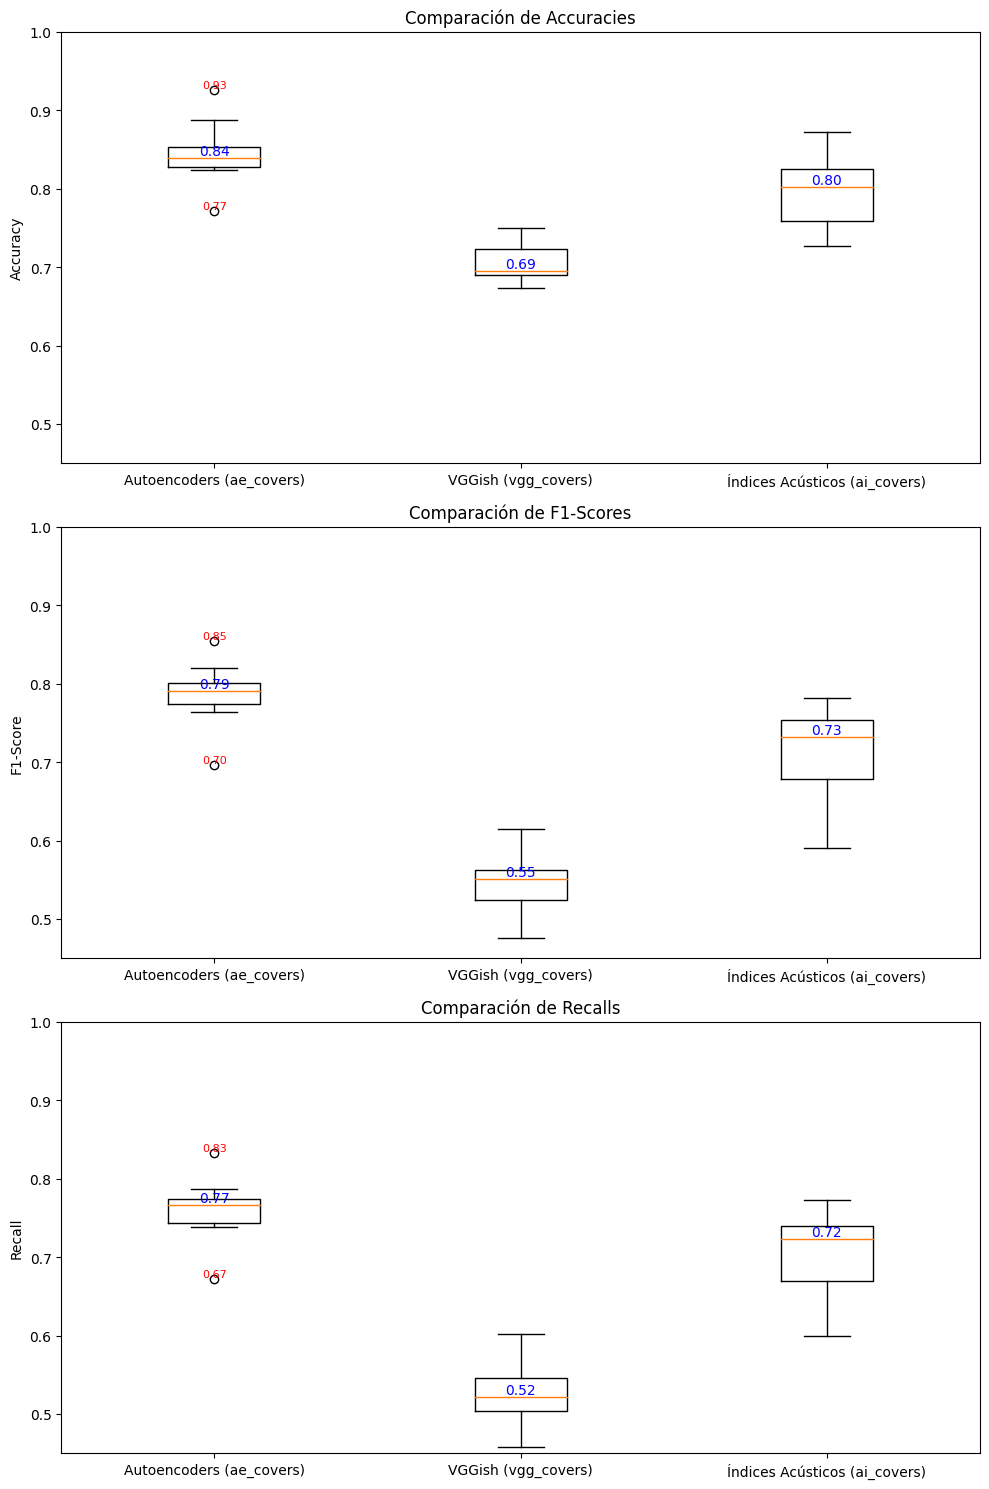

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Establecer límites del eje y
y_min = 0.45
y_max = 1

# Función para agregar anotaciones de mediana y outliers
def add_annotations(ax, data):
    for i, d in enumerate(data):
        # Añadir la mediana
        median = np.median(d)
        ax.text(i + 1, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
        
        # Añadir los outliers
        outliers = [point for point in d if point > np.percentile(d, 75) + 1.5 * (np.percentile(d, 75) - np.percentile(d, 25)) or point < np.percentile(d, 25) - 1.5 * (np.percentile(d, 75) - np.percentile(d, 25))]
        for outlier in outliers:
            ax.text(i + 1, outlier, f'{outlier:.2f}', ha='center', va='bottom', color='red', fontsize=8)

# Gráfica de accuracies
bp_acc = axs[0].boxplot([accuracies_ae_covers, accuracies_vgg_covers, accuracies_ai_covers], labels=['Autoencoders (ae_covers)', 'VGGish (vgg_covers)', 'Índices Acústicos (ai_covers)'])
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[0], [accuracies_ae_covers, accuracies_vgg_covers, accuracies_ai_covers])

# Gráfica de F1-scores
bp_f1 = axs[1].boxplot([f1_scores_ae_covers, f1_scores_vgg_covers, f1_scores_ai_covers], labels=['Autoencoders (ae_covers)', 'VGGish (vgg_covers)', 'Índices Acústicos (ai_covers)'])
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[1], [f1_scores_ae_covers, f1_scores_vgg_covers, f1_scores_ai_covers])

# Gráfica de Recalls
bp_rec = axs[2].boxplot([recalls_ae_covers, recalls_vgg_covers, recalls_ai_covers], labels=['Autoencoders (ae_covers)', 'VGGish (vgg_covers)', 'Índices Acústicos (ai_covers)'])
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[2], [recalls_ae_covers, recalls_vgg_covers, recalls_ai_covers])

# Mostrar las gráficas
plt.tight_layout()
plt.show()

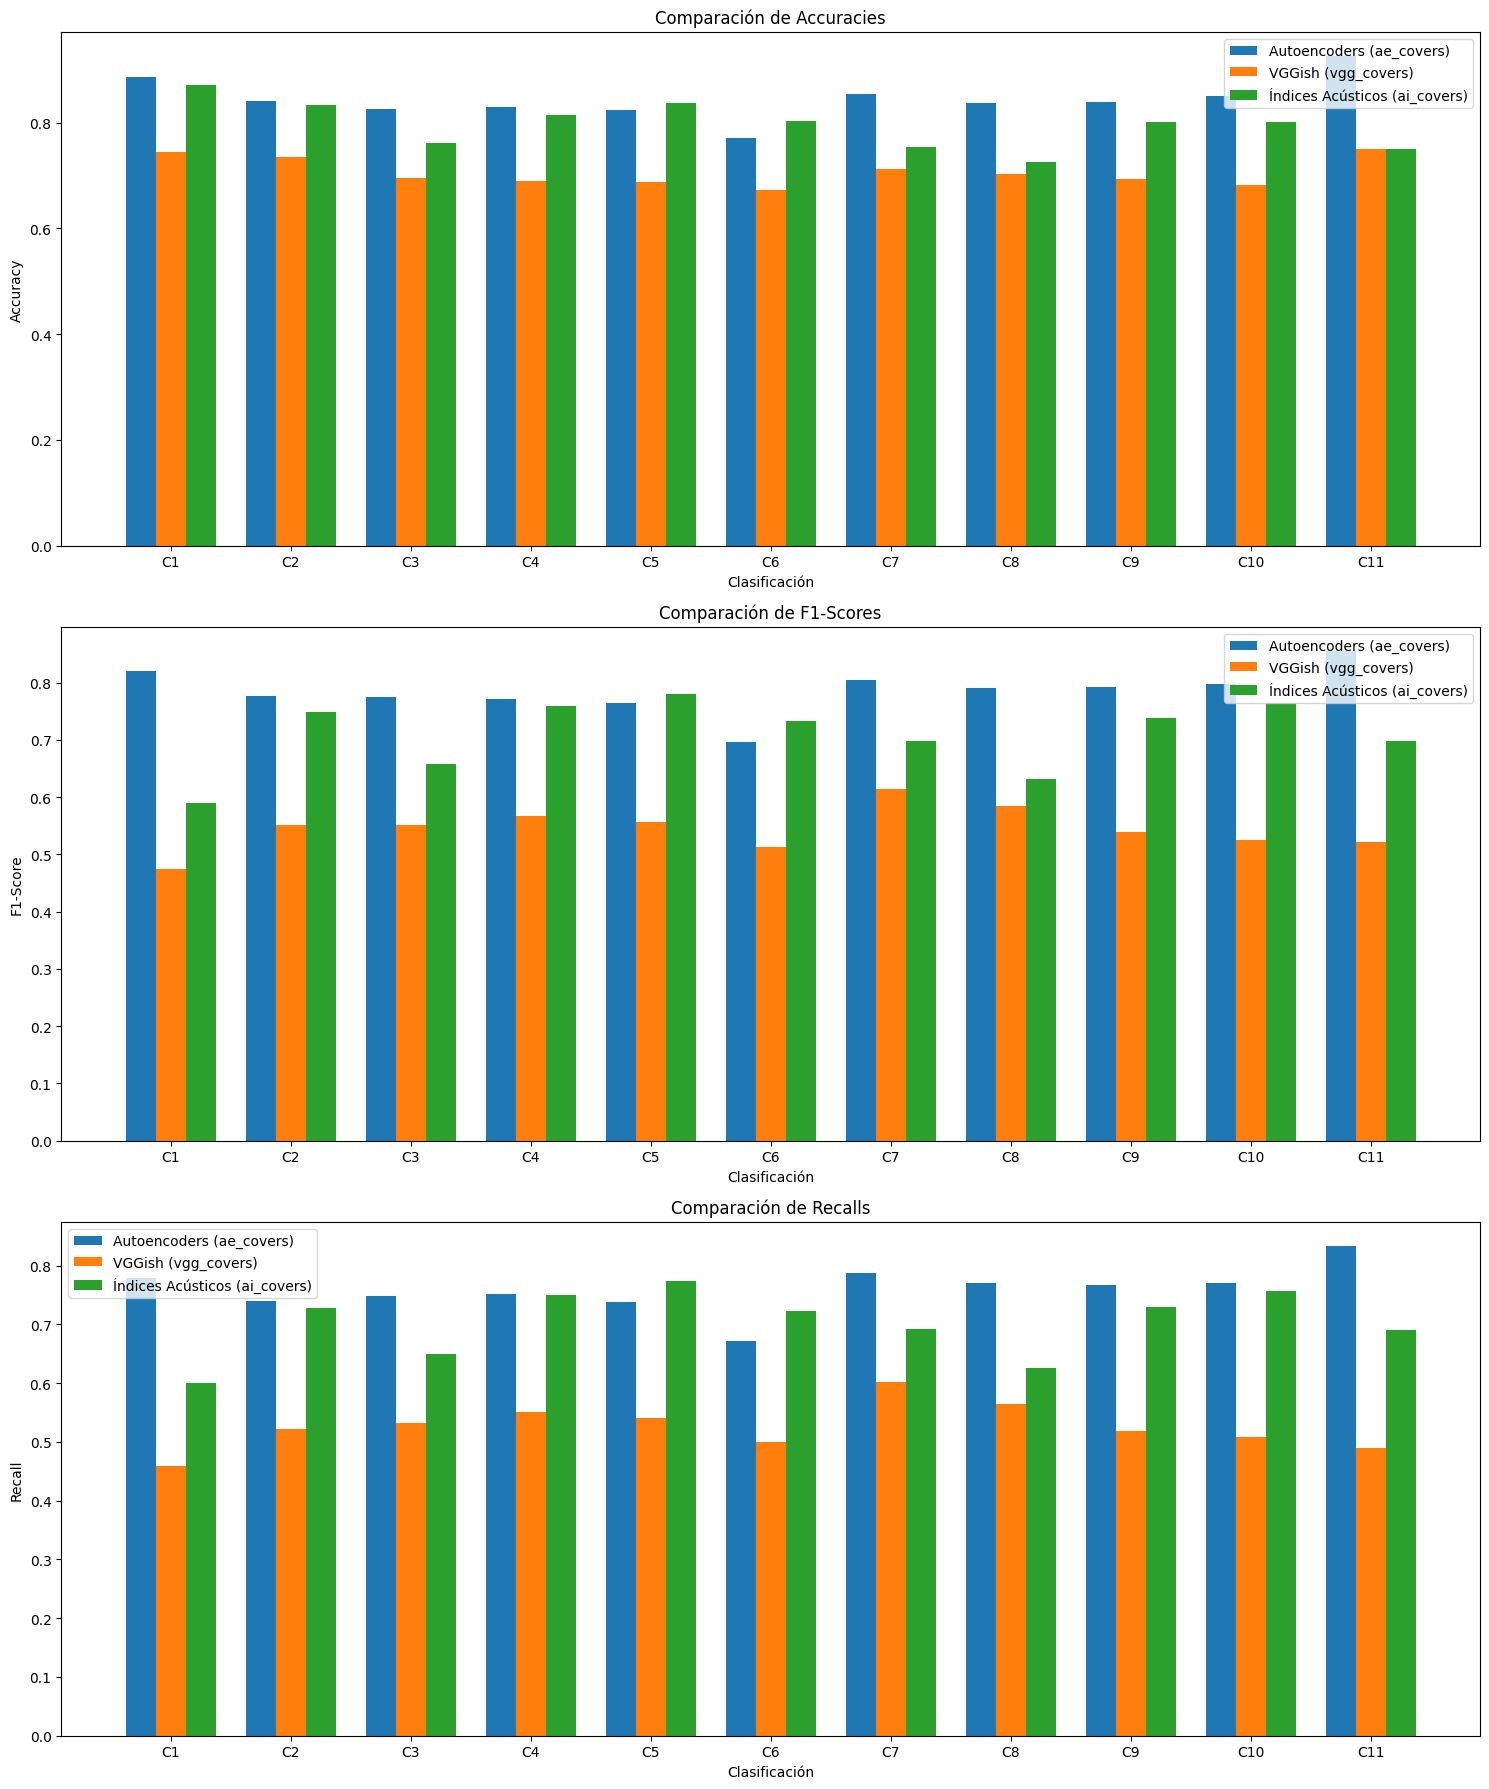

In [25]:
n = len(accuracies_ae_covers)

# Posiciones para las barras
ind = np.arange(n)  # la posición de las barras en el eje X
width = 0.25  # el ancho de las barras

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind - width, accuracies_ae_covers, width, label='Autoencoders (ae_covers)')
axs[0].bar(ind, accuracies_vgg_covers, width, label='VGGish (vgg_covers)')
axs[0].bar(ind + width, accuracies_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Clasificación')
axs[0].set_xticks(ind)
axs[0].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind - width, f1_scores_ae_covers, width, label='Autoencoders (ae_covers)')
axs[1].bar(ind, f1_scores_vgg_covers, width, label='VGGish (vgg_covers)')
axs[1].bar(ind + width, f1_scores_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xlabel('Clasificación')
axs[1].set_xticks(ind)
axs[1].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind - width, recalls_ae_covers, width, label='Autoencoders (ae_covers)')
axs[2].bar(ind, recalls_vgg_covers, width, label='VGGish (vgg_covers)')
axs[2].bar(ind + width, recalls_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xlabel('Clasificación')
axs[2].set_xticks(ind)
axs[2].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

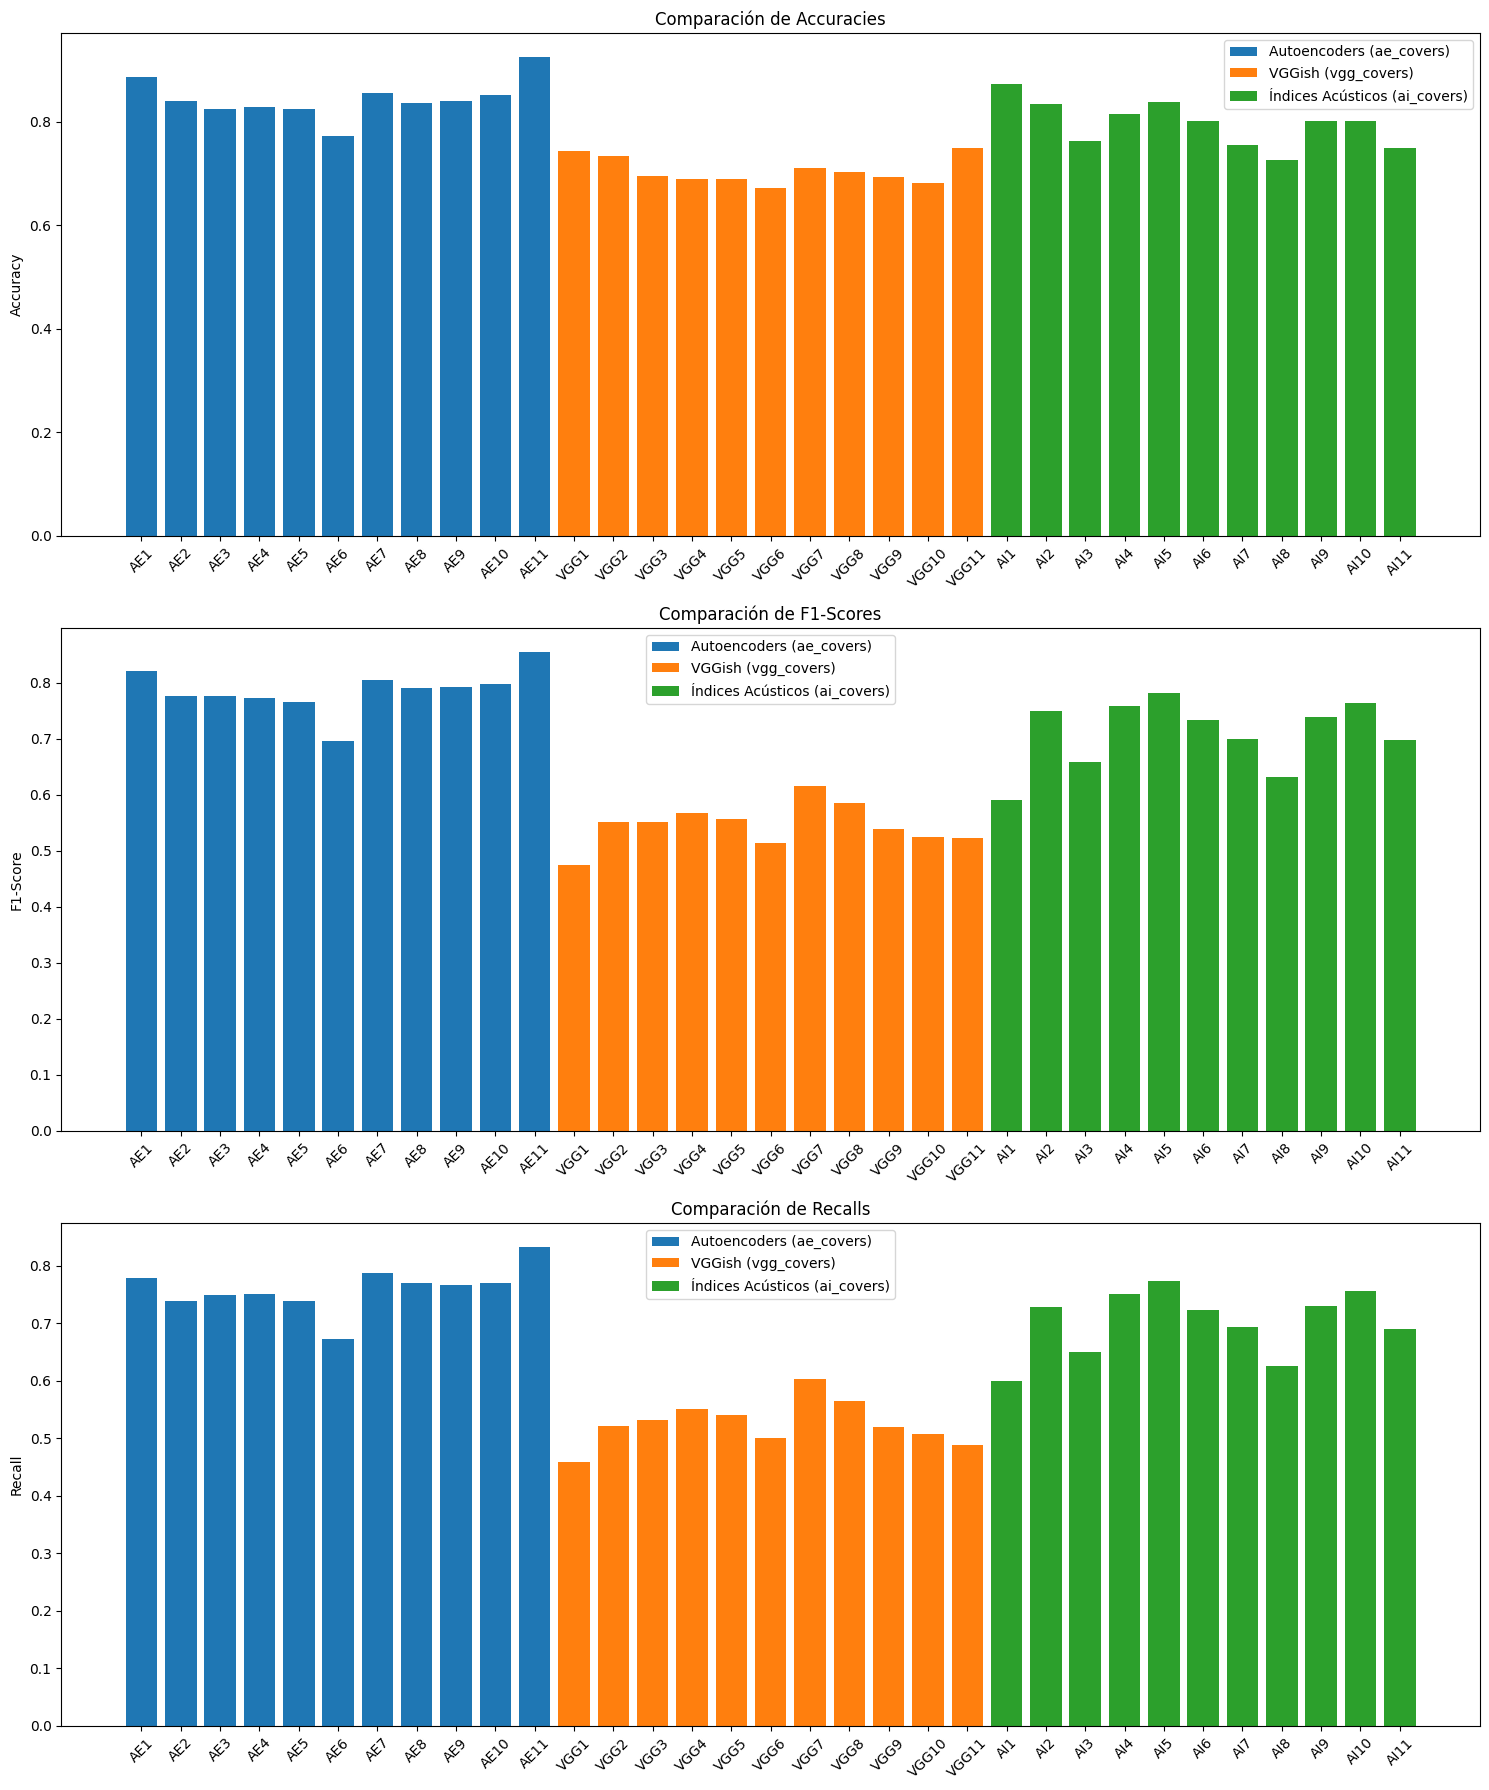

In [26]:
n = len(accuracies_ae_covers)

# Posiciones para las barras en el eje X
ind_ae = np.arange(n)  # Posiciones de las barras para el método AE
ind_vgg = np.arange(n, 2*n)  # Posiciones de las barras para el método VGGish
ind_ai = np.arange(2*n, 3*n)  # Posiciones de las barras para el método AI

# Ancho de las barras
width = 0.8  # el ancho de las barras, más amplio para que las barras estén más juntas dentro de cada grupo

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind_ae, accuracies_ae_covers, width, label='Autoencoders (ae_covers)')
axs[0].bar(ind_vgg, accuracies_vgg_covers, width, label='VGGish (vgg_covers)')
axs[0].bar(ind_ai, accuracies_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[0].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind_ae, f1_scores_ae_covers, width, label='Autoencoders (ae_covers)')
axs[1].bar(ind_vgg, f1_scores_vgg_covers, width, label='VGGish (vgg_covers)')
axs[1].bar(ind_ai, f1_scores_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[1].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind_ae, recalls_ae_covers, width, label='Autoencoders (ae_covers)')
axs[2].bar(ind_vgg, recalls_vgg_covers, width, label='VGGish (vgg_covers)')
axs[2].bar(ind_ai, recalls_ai_covers, width, label='Índices Acústicos (ai_covers)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[2].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

In [28]:
from scipy.stats import friedmanchisquare, wilcoxon
friedman_acc = friedmanchisquare(accuracies_ae_covers, accuracies_vgg_covers, accuracies_ai_covers)
friedman_f1 = friedmanchisquare(f1_scores_ae_covers, f1_scores_vgg_covers, f1_scores_ai_covers)
friedman_rec = friedmanchisquare(recalls_ae_covers, recalls_vgg_covers, recalls_ai_covers)

print(f"Friedman Test for Accuracies: Statistic={friedman_acc.statistic}, p-value={friedman_acc.pvalue}")
print(f"Friedman Test for F1-Scores: Statistic={friedman_f1.statistic}, p-value={friedman_f1.pvalue}")
print(f"Friedman Test for Recalls: Statistic={friedman_rec.statistic}, p-value={friedman_rec.pvalue}")

Friedman Test for Accuracies: Statistic=18.000000000000004, p-value=0.0001234098040866794
Friedman Test for F1-Scores: Statistic=18.72727272727272, p-value=8.578757601575079e-05
Friedman Test for Recalls: Statistic=18.72727272727272, p-value=8.578757601575079e-05


In [29]:
wilcoxon_acc_ae_vgg = wilcoxon(accuracies_ae_covers, accuracies_vgg_covers)
wilcoxon_acc_ae_ai = wilcoxon(accuracies_ae_covers, accuracies_ai_covers)

wilcoxon_f1_ae_vgg = wilcoxon(f1_scores_ae_covers, f1_scores_vgg_covers)
wilcoxon_f1_ae_ai = wilcoxon(f1_scores_ae_covers, f1_scores_ai_covers)

wilcoxon_rec_ae_vgg = wilcoxon(recalls_ae_covers, recalls_vgg_covers)
wilcoxon_rec_ae_ai = wilcoxon(recalls_ae_covers, recalls_ai_covers)

print(f"Wilcoxon Test Accuracies AE vs VGG: Statistic={wilcoxon_acc_ae_vgg.statistic}, p-value={wilcoxon_acc_ae_vgg.pvalue}")
print(f"Wilcoxon Test Accuracies AE vs AI: Statistic={wilcoxon_acc_ae_ai.statistic}, p-value={wilcoxon_acc_ae_ai.pvalue}")

print(f"Wilcoxon Test F1-Scores AE vs VGG: Statistic={wilcoxon_f1_ae_vgg.statistic}, p-value={wilcoxon_f1_ae_vgg.pvalue}")
print(f"Wilcoxon Test F1-Scores AE vs AI: Statistic={wilcoxon_f1_ae_ai.statistic}, p-value={wilcoxon_f1_ae_ai.pvalue}")

print(f"Wilcoxon Test Recalls AE vs VGG: Statistic={wilcoxon_rec_ae_vgg.statistic}, p-value={wilcoxon_rec_ae_vgg.pvalue}")
print(f"Wilcoxon Test Recalls AE vs AI: Statistic={wilcoxon_rec_ae_ai.statistic}, p-value={wilcoxon_rec_ae_ai.pvalue}")

Wilcoxon Test Accuracies AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Accuracies AE vs AI: Statistic=7.0, p-value=0.0185546875
Wilcoxon Test F1-Scores AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test F1-Scores AE vs AI: Statistic=7.0, p-value=0.0185546875
Wilcoxon Test Recalls AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Recalls AE vs AI: Statistic=10.0, p-value=0.0419921875


## Graphics Hours

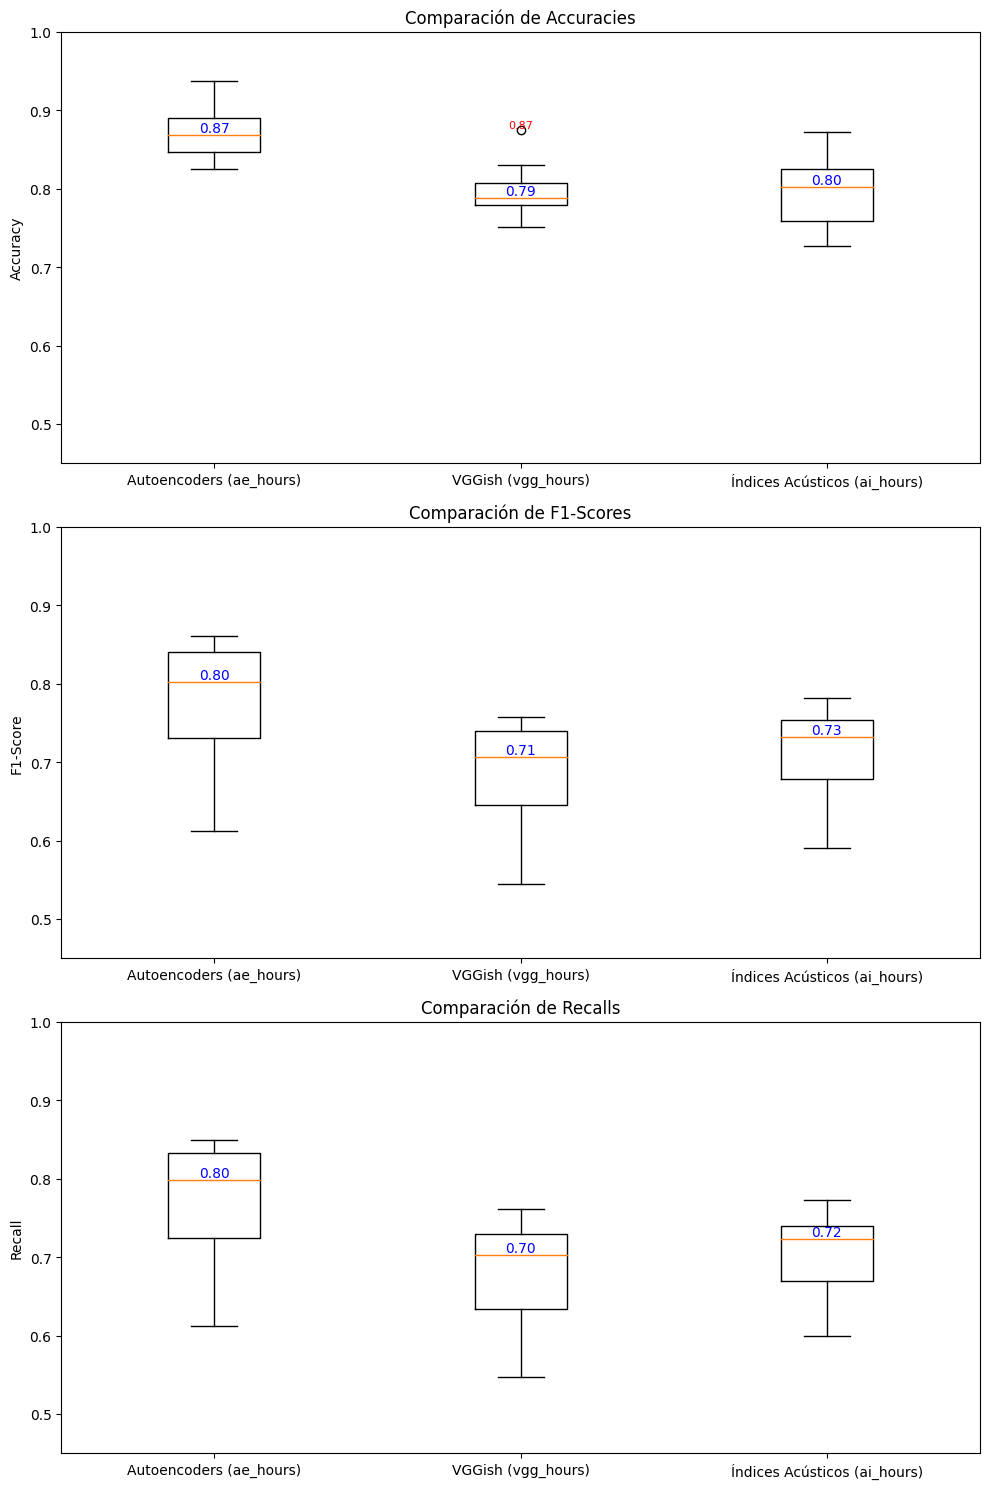

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Establecer límites del eje y
y_min = 0.45
y_max = 1

# Función para agregar anotaciones de mediana y outliers
def add_annotations(ax, data):
    for i, d in enumerate(data):
        # Añadir la mediana
        median = np.median(d)
        ax.text(i + 1, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
        
        # Añadir los outliers
        outliers = [point for point in d if point > np.percentile(d, 75) + 1.5 * (np.percentile(d, 75) - np.percentile(d, 25)) or point < np.percentile(d, 25) - 1.5 * (np.percentile(d, 75) - np.percentile(d, 25))]
        for outlier in outliers:
            ax.text(i + 1, outlier, f'{outlier:.2f}', ha='center', va='bottom', color='red', fontsize=8)

# Gráfica de accuracies
bp_acc = axs[0].boxplot([accuracies_ae_hours, accuracies_vgg_hours, accuracies_ai_hours], labels=['Autoencoders (ae_hours)', 'VGGish (vgg_hours)', 'Índices Acústicos (ai_hours)'])
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[0], [accuracies_ae_hours, accuracies_vgg_hours, accuracies_ai_hours])

# Gráfica de F1-scores
bp_f1 = axs[1].boxplot([f1_scores_ae_hours, f1_scores_vgg_hours, f1_scores_ai_hours], labels=['Autoencoders (ae_hours)', 'VGGish (vgg_hours)', 'Índices Acústicos (ai_hours)'])
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[1], [f1_scores_ae_hours, f1_scores_vgg_hours, f1_scores_ai_hours])

# Gráfica de Recalls
bp_rec = axs[2].boxplot([recalls_ae_hours, recalls_vgg_hours, recalls_ai_hours], labels=['Autoencoders (ae_hours)', 'VGGish (vgg_hours)', 'Índices Acústicos (ai_hours)'])
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_ylim(y_min, y_max)  # Límite del eje y
add_annotations(axs[2], [recalls_ae_hours, recalls_vgg_hours, recalls_ai_hours])

# Mostrar las gráficas
plt.tight_layout()
plt.show()

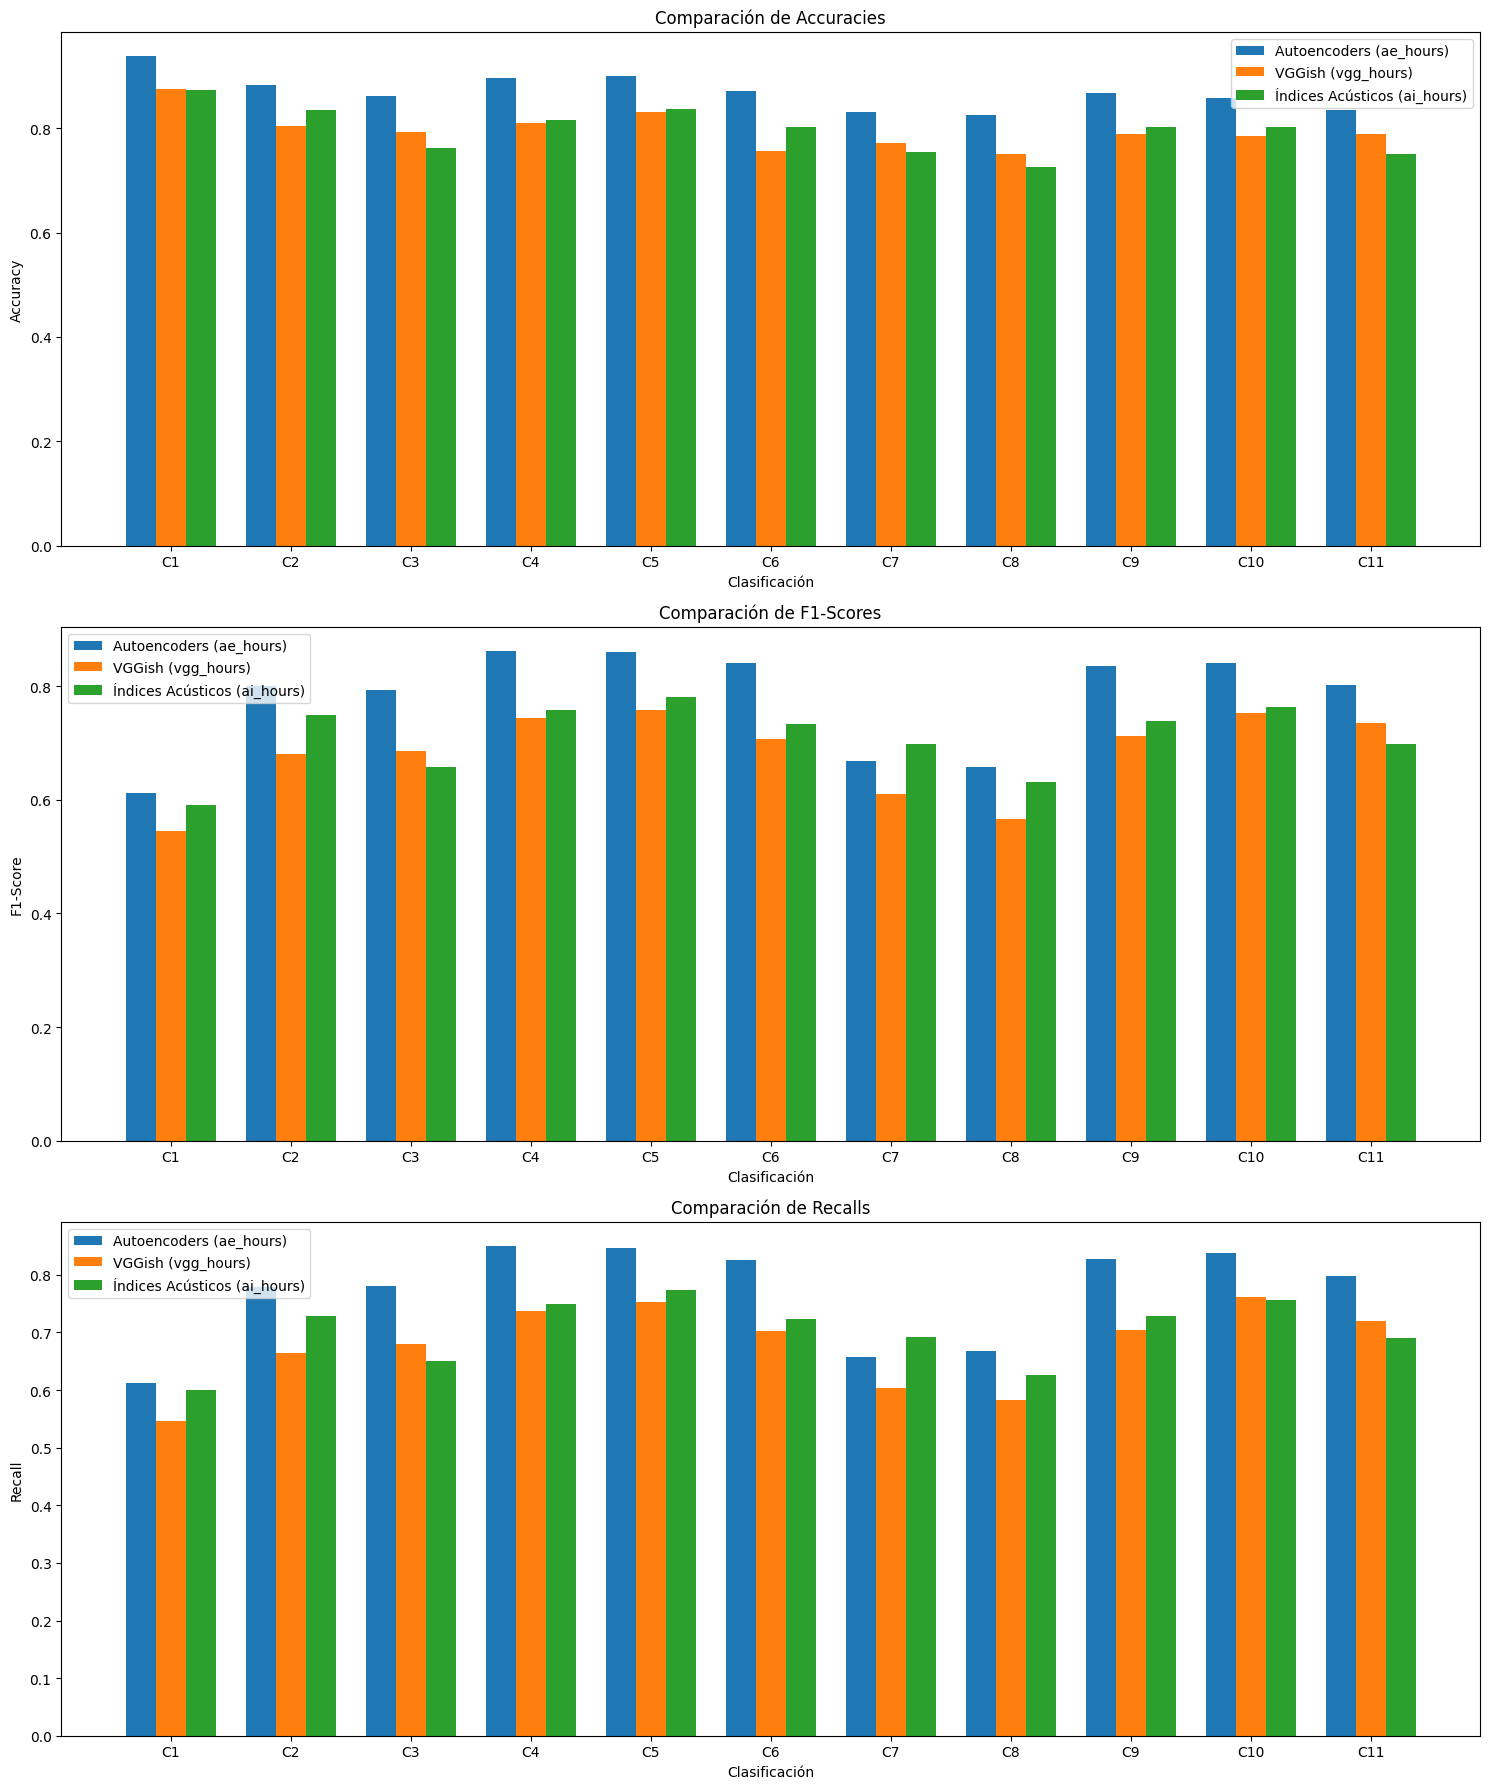

In [37]:
n = len(accuracies_ae_hours)

# Posiciones para las barras
ind = np.arange(n)  # la posición de las barras en el eje X
width = 0.25  # el ancho de las barras

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind - width, accuracies_ae_hours, width, label='Autoencoders (ae_hours)')
axs[0].bar(ind, accuracies_vgg_hours, width, label='VGGish (vgg_hours)')
axs[0].bar(ind + width, accuracies_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Clasificación')
axs[0].set_xticks(ind)
axs[0].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind - width, f1_scores_ae_hours, width, label='Autoencoders (ae_hours)')
axs[1].bar(ind, f1_scores_vgg_hours, width, label='VGGish (vgg_hours)')
axs[1].bar(ind + width, f1_scores_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xlabel('Clasificación')
axs[1].set_xticks(ind)
axs[1].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind - width, recalls_ae_hours, width, label='Autoencoders (ae_hours)')
axs[2].bar(ind, recalls_vgg_hours, width, label='VGGish (vgg_hours)')
axs[2].bar(ind + width, recalls_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xlabel('Clasificación')
axs[2].set_xticks(ind)
axs[2].set_xticklabels([f'C{i+1}' for i in ind])  # Etiquetas para cada clasificación
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

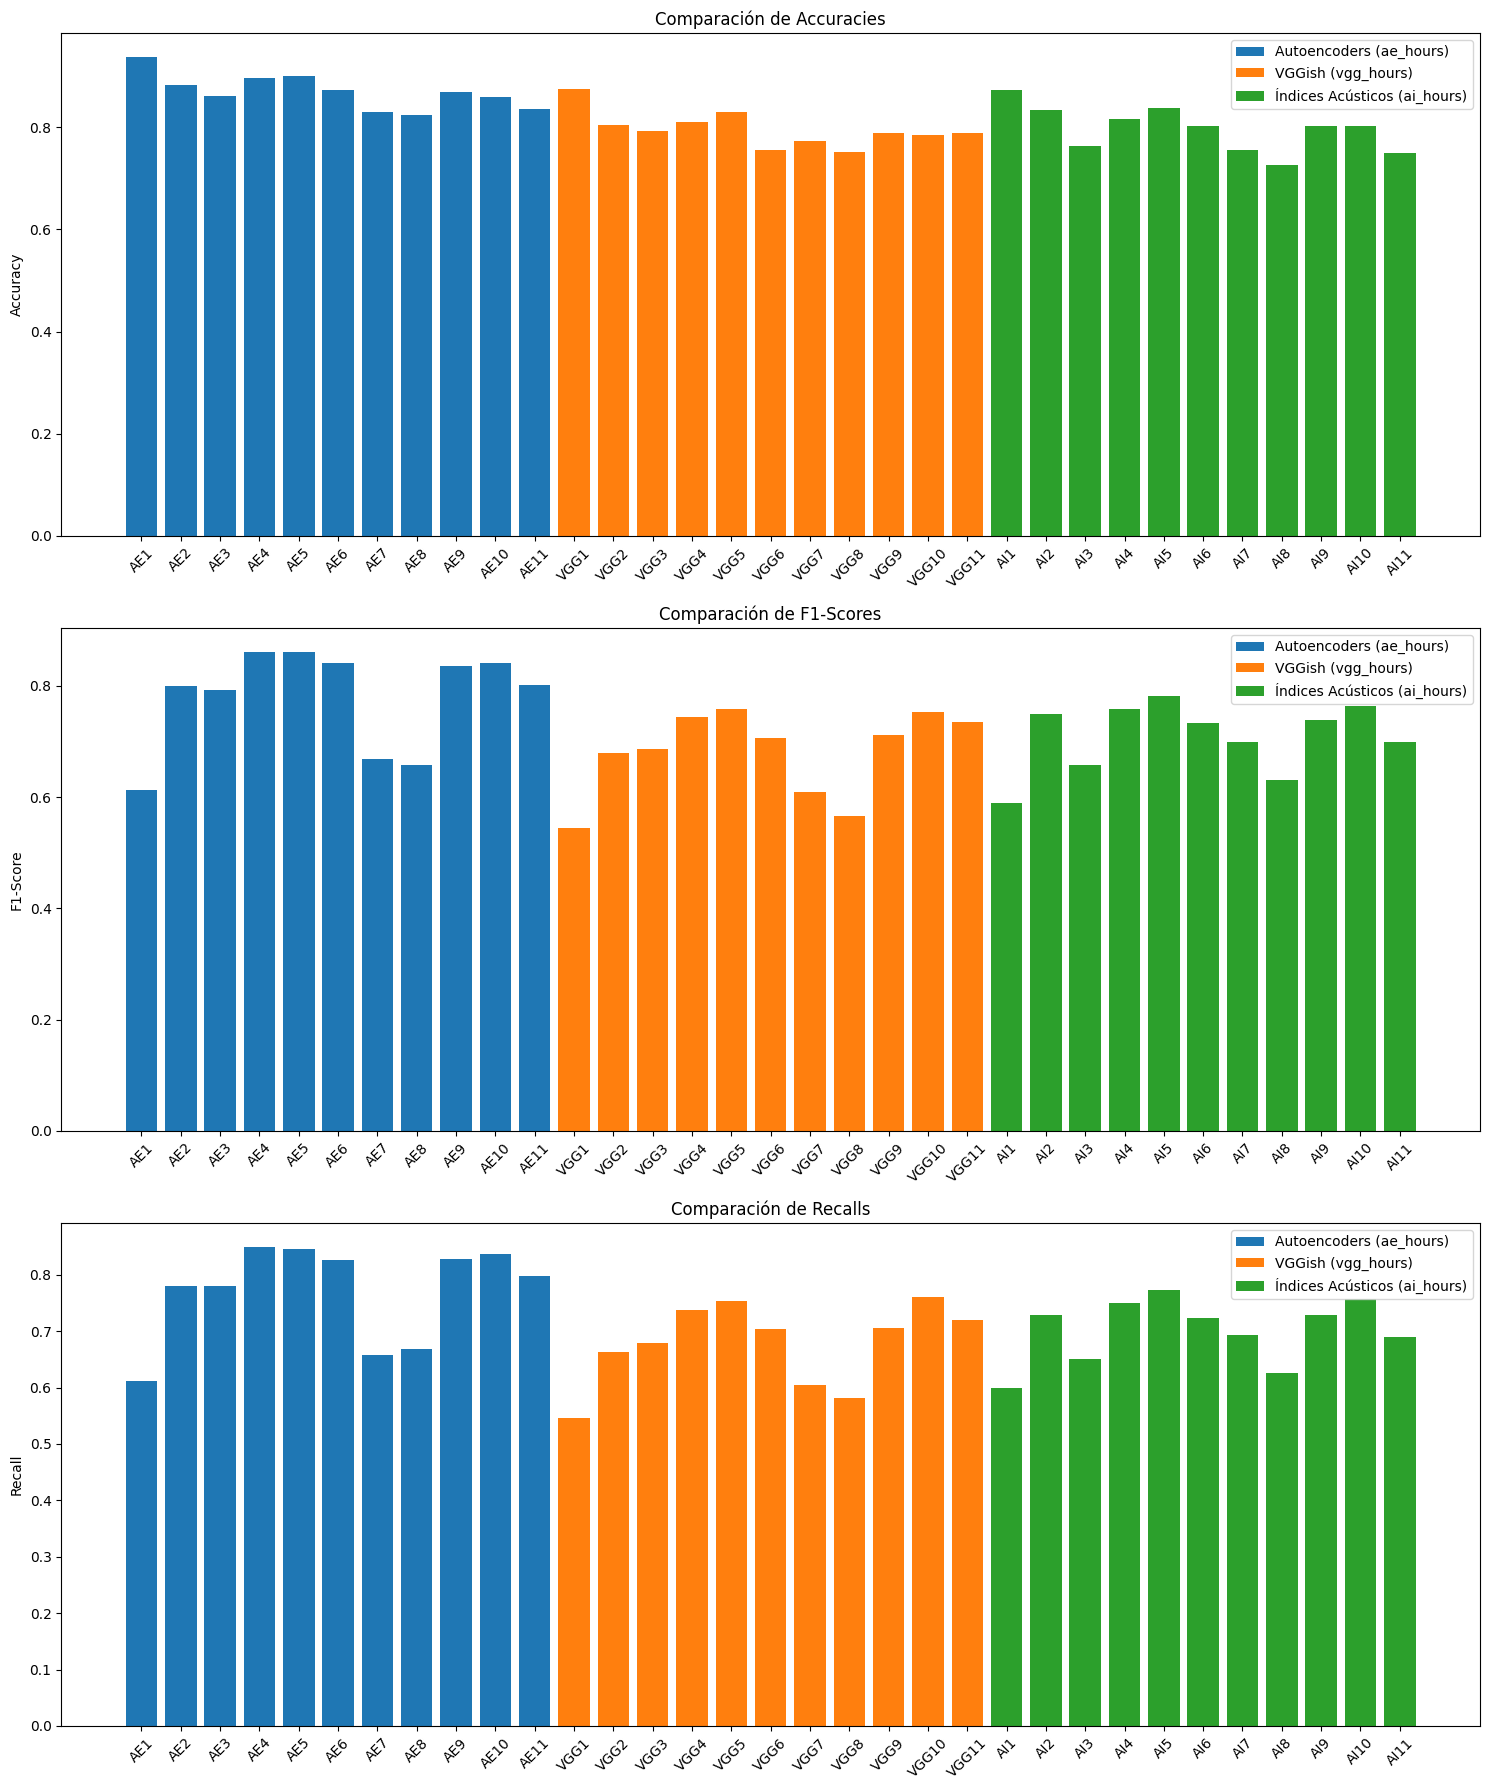

In [38]:
n = len(accuracies_ae_hours)

# Posiciones para las barras en el eje X
ind_ae = np.arange(n)  # Posiciones de las barras para el método AE
ind_vgg = np.arange(n, 2*n)  # Posiciones de las barras para el método VGGish
ind_ai = np.arange(2*n, 3*n)  # Posiciones de las barras para el método AI

# Ancho de las barras
width = 0.8  # el ancho de las barras, más amplio para que las barras estén más juntas dentro de cada grupo

fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Gráfica de accuracies
axs[0].bar(ind_ae, accuracies_ae_hours, width, label='Autoencoders (ae_hours)')
axs[0].bar(ind_vgg, accuracies_vgg_hours, width, label='VGGish (vgg_hours)')
axs[0].bar(ind_ai, accuracies_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[0].set_title('Comparación de Accuracies')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[0].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[0].legend(loc='best')

# Gráfica de F1-scores
axs[1].bar(ind_ae, f1_scores_ae_hours, width, label='Autoencoders (ae_hours)')
axs[1].bar(ind_vgg, f1_scores_vgg_hours, width, label='VGGish (vgg_hours)')
axs[1].bar(ind_ai, f1_scores_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[1].set_title('Comparación de F1-Scores')
axs[1].set_ylabel('F1-Score')
axs[1].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[1].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[1].legend(loc='best')

# Gráfica de Recalls
axs[2].bar(ind_ae, recalls_ae_hours, width, label='Autoencoders (ae_hours)')
axs[2].bar(ind_vgg, recalls_vgg_hours, width, label='VGGish (vgg_hours)')
axs[2].bar(ind_ai, recalls_ai_hours, width, label='Índices Acústicos (ai_hours)')
axs[2].set_title('Comparación de Recalls')
axs[2].set_ylabel('Recall')
axs[2].set_xticks(np.concatenate([ind_ae, ind_vgg, ind_ai]))
axs[2].set_xticklabels(['AE'+str(i+1) for i in range(n)] + ['VGG'+str(i+1) for i in range(n)] + ['AI'+str(i+1) for i in range(n)], rotation=45)
axs[2].legend(loc='best')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()

In [39]:
from scipy.stats import friedmanchisquare, wilcoxon
friedman_acc = friedmanchisquare(accuracies_ae_hours, accuracies_vgg_hours, accuracies_ai_hours)
friedman_f1 = friedmanchisquare(f1_scores_ae_hours, f1_scores_vgg_hours, f1_scores_ai_hours)
friedman_rec = friedmanchisquare(recalls_ae_hours, recalls_vgg_hours, recalls_ai_hours)

print(f"Friedman Test for Accuracies: Statistic={friedman_acc.statistic}, p-value={friedman_acc.pvalue}")
print(f"Friedman Test for F1-Scores: Statistic={friedman_f1.statistic}, p-value={friedman_f1.pvalue}")
print(f"Friedman Test for Recalls: Statistic={friedman_rec.statistic}, p-value={friedman_rec.pvalue}")

Friedman Test for Accuracies: Statistic=16.54545454545456, p-value=0.00025538782834452984
Friedman Test for F1-Scores: Statistic=16.54545454545456, p-value=0.00025538782834452984
Friedman Test for Recalls: Statistic=15.27272727272728, p-value=0.0004825801020447375


In [41]:
wilcoxon_acc_ae_vgg = wilcoxon(accuracies_ae_hours, accuracies_vgg_hours)
wilcoxon_acc_ae_ai = wilcoxon(accuracies_ae_hours, accuracies_ai_hours)

wilcoxon_f1_ae_vgg = wilcoxon(f1_scores_ae_hours, f1_scores_vgg_hours)
wilcoxon_f1_ae_ai = wilcoxon(f1_scores_ae_hours, f1_scores_ai_hours)

wilcoxon_rec_ae_vgg = wilcoxon(recalls_ae_hours, recalls_vgg_hours)
wilcoxon_rec_ae_ai = wilcoxon(recalls_ae_hours, recalls_ai_hours)

print(f"Wilcoxon Test Accuracies AE vs VGG: Statistic={wilcoxon_acc_ae_vgg.statistic}, p-value={wilcoxon_acc_ae_vgg.pvalue}")
print(f"Wilcoxon Test Accuracies AE vs AI: Statistic={wilcoxon_acc_ae_ai.statistic}, p-value={wilcoxon_acc_ae_ai.pvalue}")

print(f"Wilcoxon Test F1-Scores AE vs VGG: Statistic={wilcoxon_f1_ae_vgg.statistic}, p-value={wilcoxon_f1_ae_vgg.pvalue}")
print(f"Wilcoxon Test F1-Scores AE vs AI: Statistic={wilcoxon_f1_ae_ai.statistic}, p-value={wilcoxon_f1_ae_ai.pvalue}")

print(f"Wilcoxon Test Recalls AE vs VGG: Statistic={wilcoxon_rec_ae_vgg.statistic}, p-value={wilcoxon_rec_ae_vgg.pvalue}")
print(f"Wilcoxon Test Recalls AE vs AI: Statistic={wilcoxon_rec_ae_ai.statistic}, p-value={wilcoxon_rec_ae_ai.pvalue}")

Wilcoxon Test Accuracies AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Accuracies AE vs AI: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test F1-Scores AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test F1-Scores AE vs AI: Statistic=3.0, p-value=0.0048828125
Wilcoxon Test Recalls AE vs VGG: Statistic=0.0, p-value=0.0009765625
Wilcoxon Test Recalls AE vs AI: Statistic=2.0, p-value=0.0029296875
